## General imports

In [1]:
import os
import pickle
import numpy as np

from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Tensorflow imports

In [2]:
import tensorflow as tf

# silencing tensorflow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

tf.__version__ # printint out tensorflow version used

'1.15.0'

## Stable-Baselines import

In [3]:
import stable_baselines
from stable_baselines.common.callbacks import BaseCallback
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines import DQN
from stable_baselines.bench import Monitor
from stable_baselines.deepq.policies import MlpPolicy as DQN_MlpPolicy
from stable_baselines import results_plotter
stable_baselines.__version__ # printing out stable_baselines version used

/home/mgonzalezh/anaconda3/envs/RLGym-CR/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):
/home/mgonzalezh/anaconda3/envs/RLGym-CR/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


'2.10.2'

## Environment imports

In [4]:
import gym

## Callback function

In [5]:
# callback from https://stable-baselines.readthedocs.io/en/master/guide/examples.html#using-callback-monitoring-training
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                 # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {} - ".format(self.num_timesteps), end="")
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))
                  # New best model, you could save the agent here, after certain number of steps to handle transient training.
                if mean_reward > self.best_mean_reward and self.num_timesteps > 10000:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                        self.model.save(self.save_path)
                if self.verbose > 0:
                    clear_output(wait=True)

        return True

## Environment setting

In [6]:
# loading the topology binary file containing the graph and the k-shortest paths
topology_name = 'nsfnet_eon'
k_paths = 5
with open(f'../examples/topologies/{topology_name}_{k_paths}-paths.h5', 'rb') as f:
    topology = pickle.load(f)

# node probabilities from https://github.com/xiaoliangchenUCD/DeepRMSA/blob/6708e9a023df1ec05bfdc77804b6829e33cacfe4/Deep_RMSA_A3C.py#L77
node_request_probabilities = np.array([0.01801802, 0.04004004, 0.05305305, 0.01901902, 0.04504505,
                                       0.02402402, 0.06706707, 0.08908909, 0.13813814, 0.12212212,
                                       0.07607608, 0.12012012, 0.01901902, 0.16916917])

# Scenario to run: 1=Band C, 2=Bands C+L, 3=Bands C+L+S, 4=Bands C+L+S+E
scenario = 4
# Reward function used: 0=Baseline, 1=Dynamic, 2=Static, 3=Mixed
reward_function = 3

env_args = dict(scenario=scenario, load=1000, topology=topology, seed=10,  # load is for traffic load
                allow_rejection=False,  # the agent cannot proactively reject a request
                j=1,  # consider only the first suitable spectrum block for the spectrum assignment
                # value is not set as in the paper to achieve comparable reward values
                mean_service_holding_time=200,
                # num_spectrum_resources=num_spectrum_resources,
                episode_length=50, node_request_probabilities=None, reward_function=reward_function)

env_args_baseline = dict(scenario=scenario, load=1000, topology=topology, seed=10,  # load is for traffic load
                allow_rejection=False,  # the agent cannot proactively reject a request
                j=1,  # consider only the first suitable spectrum block for the spectrum assignment
                # value is not set as in the paper to achieve comparable reward values
                mean_service_holding_time=200,
                # num_spectrum_resources=num_spectrum_resources,
                episode_length=50, node_request_probabilities=None, reward_function=0)


## Creating monitors and agent

In [7]:
# Create log dir
log_dir = "./tmp/deeptest-dqn/"     # logs will be saved in log_dir/training.monitor.csv
os.makedirs(log_dir, exist_ok=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir)

env = gym.make('DeepRBMLSACR-v0', **env_args)
# in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
# for more information about the monitor, check https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor
env = Monitor(env, log_dir + 'training', info_keywords=('service_blocking_rate_since_reset','bit_rate_blocking_rate_since_reset', 'band', 'slots'))

# here goes the arguments of the policy network to be used
policy_args = dict(layers=5*[128], # the neural network has five layers with 128 neurons each
                   act_fun=tf.nn.elu)    # we use the elu activation function

agent = DQN(DQN_MlpPolicy, env, verbose=0, tensorboard_log="./tb/DQN-DeepRBMLSA_Cr-v0/", policy_kwargs=policy_args, gamma=.95)

In [8]:
# Create log dir
log_dir_baseline = "./tmp/deeptest-dqn-baseline/"     # logs will be saved in log_dir/training.monitor.csv
os.makedirs(log_dir_baseline, exist_ok=True)
callback_baseline = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir_baseline)

env_baseline = gym.make('DeepRBMLSACR-v0', **env_args)
# in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
# for more information about the monitor, check https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor
env_baseline = Monitor(env_baseline, log_dir_baseline + 'training', info_keywords=('service_blocking_rate_since_reset','bit_rate_blocking_rate_since_reset', 'band', 'slots'))

# here goes the arguments of the policy network to be used
policy_args = dict(layers=5*[128], # the neural network has five layers with 128 neurons each
                   act_fun=tf.nn.elu)    # we use the elu activation function

agent_baseline = DQN(DQN_MlpPolicy, env_baseline, verbose=0, tensorboard_log="./tb/DQN-DeepRBMLSA_Cr-baseline-v0/", policy_kwargs=policy_args, gamma=.95)

## Training the agents

In [9]:
a = agent.learn(total_timesteps=100000, callback=callback)

Num timesteps: 100000 - Best mean reward: 51.82 - Last mean reward per episode: 50.05


In [9]:
a_baseline = agent_baseline.learn(total_timesteps=100000, callback=callback_baseline)

Num timesteps: 700 - Best mean reward: -inf - Last mean reward per episode: 68.47


## Plotting the training progress

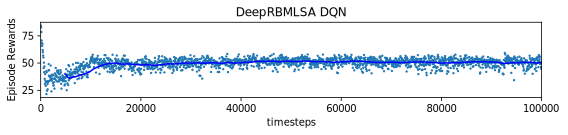

In [26]:
import matplotlib.pyplot as plt

results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "DeepRBMLSA DQN")
plt.savefig('deeprmsa_uniform.png')

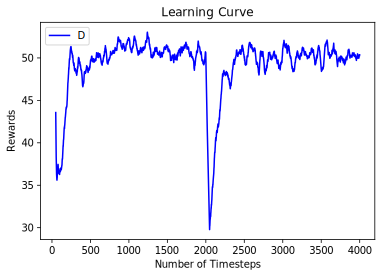

IndexError: list index out of range

In [28]:
import matplotlib.pyplot as plt

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results
    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'episodes')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y, color='BLUE')
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.gca().legend(('DQN'))
    plt.title(title)
    plt.show()


plot_results(log_dir)

# Load the Pandas libraries with alias 'pd' 
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./tmp/deeptest-dqn/training.monitor.csv', skiprows=1)
data_baseline = pd.read_csv('./tmp/deeptest-dqn-baseline/training.monitor.csv', skiprows=1)

stats = data.values  #stats[0] = 'episode_service_blocking_rate', 'episode_bit_rate_blocking_rate'
stats_baseline = data_baseline.values
block_prob = data.service_blocking_rate_since_reset.tolist() #Selects only the blocking probability
block_prob_baseline = data_baseline.service_blocking_rate_since_reset.tolist()

lista = []
lista_baseline = []

for i in range(len(block_prob)):
    lista.append(float(block_prob[i]))
    lista_baseline.append(float(block_prob_baseline[i]))
    
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

y = moving_average(lista, 50)
y_baseline = moving_average(lista_baseline, 50)

f, ax1 = plt.subplots(1, 1, sharex=True, figsize=(4, 4))

plt.plot(y, color="mediumblue", linestyle="-", linewidth=0.5, label="DQN (RW3)") # marker="o"
plt.plot(y_baseline, color="green", linestyle="-", linewidth=0.5, label="DQN (RW0)") # marker="o"
ax1.set_title('Blocking Probability per Episode', fontsize=10, fontweight='normal')
plt.legend(loc='upper left')
plt.xticks(fontsize=8,fontweight='normal')
plt.yticks(fontsize=8,fontweight='normal')
plt.xlabel('Training steps', fontsize=10)
plt.ylabel('Episode Blocking Ratio', fontsize=10)
plt.xlim(0, 2000)
plt.ylim(0, 1)
plt.grid(b=None, which='major', axis='both')
plt.savefig('Blocking Probability per Episode.png')
plt.show()

block_rate_mean = np.mean(lista)
block_rate_min = min(lista)
block_rate_max = max(lista)
print("Mean blocking probability:", block_rate_mean)
print("Minimum blocking probability:", block_rate_min)
print("Maximun blocking probability:", block_rate_max)